##### 데이터 시각화할 때 한글 깨지면 실행할 코드 

In [ ]:
# 해당 셀 실행하고 런타임 다시시작 후 아래 셀 실행
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

## Import 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna

In [ ]:
!pip install bayesian-optimization

In [ ]:
#모듈들을 임포트한다.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from scipy import stats

from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import re

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# import optuna
# from optuna.integration import XGBoostPruningCallback
# sns.set_theme(style="darkgrid")

In [ ]:
path = "/content/drive/MyDrive/01.Competition/03.Create_lettuce_growing_environment_AI/Dataset/my_dataset/"

train_df = pd.read_csv(path+"train_df.csv")
valid_df = pd.read_csv(path+"valid_df.csv")
test_df = pd.read_csv(path+"test_df.csv")

train_target = pd.read_csv(path+"train_target.csv")
valid_target = pd.read_csv(path+"valid_target.csv")
test_target = pd.read_csv(path+"test_target.csv")

## Target 값 로그 변환 

In [ ]:
#descriptive statistics summary
train_target['생육일별_잎_중량'].describe()

count    644.000000
mean      36.793847
std       43.630617
min        0.167719
25%        4.989247
50%       17.268621
75%       54.982618
max      164.150300
Name: 생육일별_잎_중량, dtype: float64

<Figure size 432x288 with 0 Axes>

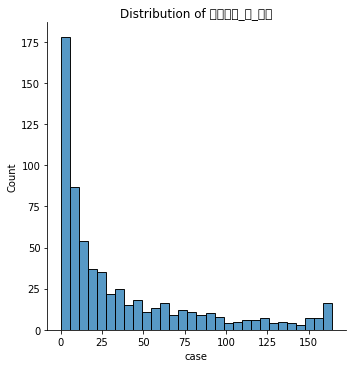

In [ ]:
plt.figure()
sns.displot(train_target['생육일별_잎_중량'], bins=30)
plt.xlabel('case')
plt.title('Distribution of 생육일별_잎_중량')
plt.show()

In [ ]:
# 가격 로그 변환 후 원래 가격 따로 저장
train_target['log_weight'] = np.log1p(train_target['생육일별_잎_중량'])
train_real_weight = train_target['생육일별_잎_중량'] # 원래 가격
print(train_target.head(1))

valid_target['log_weight'] = np.log1p(valid_target['생육일별_잎_중량'])
valid_real_weight = valid_target['생육일별_잎_중량'] # 원래 가격
print(valid_target.head(1))

      상추  생육일  생육일별_잎_중량  log_weight
0  case1    1   0.167719    0.155053
       상추  생육일  생육일별_잎_중량  log_weight
0  case24    1   0.171071    0.157919


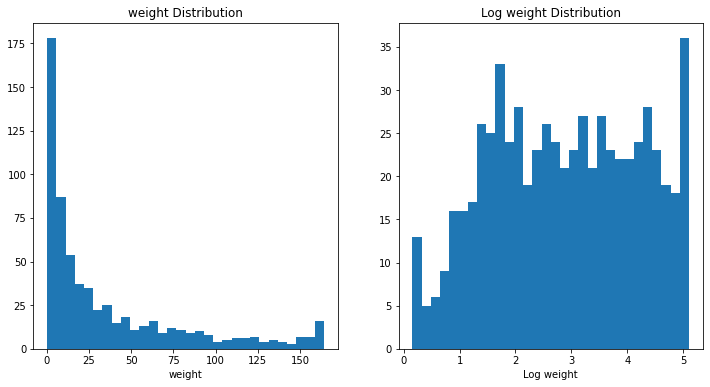

In [ ]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(train_real_weight, bins=30)
ax1.set_title('weight Distribution')
ax1.set_xlabel('weight')

ax2.hist(train_target['log_weight'], bins=30)
ax2.set_title('Log weight Distribution')
ax2.set_xlabel('Log weight')

plt.show()

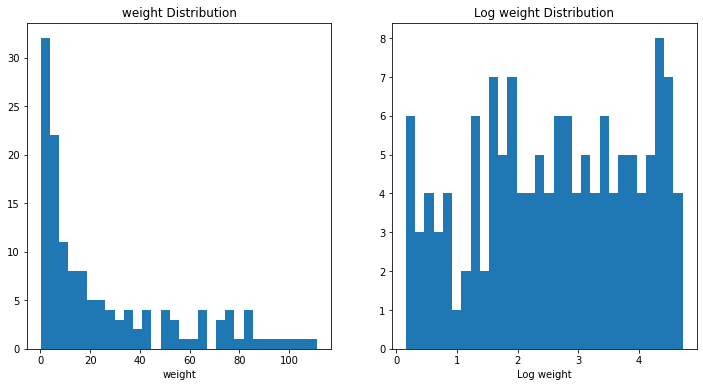

In [ ]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(valid_real_weight, bins=30)
ax1.set_title('weight Distribution')
ax1.set_xlabel('weight')

ax2.hist(valid_target['log_weight'], bins=30)
ax2.set_title('Log weight Distribution')
ax2.set_xlabel('Log weight')

plt.show()

In [ ]:
train_df.columns

Index(['상추', '생육일', '측정시간', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량',
       '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', '시간당청색광량',
       '일간누적청색광량', '시간당총광량', '일간누적총광량'],
      dtype='object')

## Feature Engineering 

In [ ]:
def ec_time(df):
  df['여름철_적정_EC관측_누적시간'] = 0

  # 여름철(8월 기준. 온도 19.7-26.7℃, 습도 78-79%) & ec관측치 1.2이상~1.3미만
  index_여름철_적정_EC관측_누적시간 = df.loc[
        ((df['내부온도관측치']>=19.7) & (df['내부온도관측치']<=26.7)) 
      & ((df['내부습도관측치']>=78) & (df['내부습도관측치']<=79))
      & ((df['ec관측치']>=1.2) & (df['ec관측치']<=1.6))].index

  # case 별로 여름철_적정_EC관측_누적시간 구하기 
  df.loc[index_여름철_적정_EC관측_누적시간, '여름철_적정_EC관측_누적시간'] = 1
  df['여름철_적정_EC관측_누적시간'] = df.groupby(['상추'])['여름철_적정_EC관측_누적시간'].apply(lambda x: x.cumsum())
  return df

train_df = ec_time(train_df)
valid_df = ec_time(valid_df)
test_df = ec_time(test_df)

In [ ]:
def light_time(df):
  df['광주기_명기_누적시간'] = 0

  index_광주기_명기_누적시간 = df.loc[df['시간당총광량']>0].index

  # case 별로 index_광주기_명기_누적시간 구하기 
  df.loc[index_광주기_명기_누적시간, '광주기_명기_누적시간'] = 1
  df['광주기_명기_누적시간'] = df.groupby(['상추', '생육일'])['광주기_명기_누적시간'].apply(lambda x: x.cumsum())
  return df

train_df = light_time(train_df)
valid_df = light_time(valid_df)
test_df = light_time(test_df)

In [ ]:
def combine_feature(df) :
    # 2* 기존 feature들 조합
    df["온도_습도"] = df["내부온도관측치"] * df["내부습도관측치"]
    df["온도_co2"] = df["내부온도관측치"] * df["co2관측치"]
    df["온도_ec"] = df["내부온도관측치"] * df["ec관측치"]
    df["온도_시간당분무량"] = df["내부온도관측치"] * df["시간당분무량"]
    df["온도_시간당총광량"] = df["내부온도관측치"] * df["시간당총광량"]
    df["온도_일간누적총광량"] = df["내부온도관측치"] * df["일간누적총광량"]

    df["습도_co2"] = df["내부습도관측치"] * df["co2관측치"]
    df["습도_ec"] = df["내부습도관측치"] * df["ec관측치"]
    df["습도_시간당분무량"] = df["내부습도관측치"] * df["시간당분무량"]
    df["습도_시간당총광량"] = df["내부습도관측치"] * df["시간당총광량"]
    df["습도_일간누적총광량"] = df["내부습도관측치"] * df["일간누적총광량"]

    df["co2_ec"] = df["co2관측치"] * df["ec관측치"]
    df["co2_시간당분무량"] = df["co2관측치"] * df["시간당분무량"]
    df["co2_시간당총광량"] = df["co2관측치"] * df["시간당총광량"]
    df["co2_일간누적총광량"] = df["co2관측치"] * df["일간누적총광량"]

    df["ec_시간당분무량"] = df["ec관측치"] * df["시간당분무량"]
    df["ec_시간당총광량"] = df["ec관측치"] * df["시간당총광량"]
    df["ec_일간누적총광량"] = df["ec관측치"] * df["일간누적총광량"]

    df["시간당분무량_시간당총광량"] = df["시간당분무량"] * df["시간당총광량"]
    df["시간당분무량_일간누적총광량"] = df["시간당분무량"] * df["일간누적총광량"]

    df["시간당총광량_일간누적총광량"] = df["시간당총광량"] * df["일간누적총광량"]


    # 3* 기존 feature들 조합
    df["온도_습도_co2"] = df["내부온도관측치"] * df["내부습도관측치"] * df["co2관측치"]
    df["온도_습도_ec"] = df["내부온도관측치"] * df["내부습도관측치"] * df["ec관측치"]
    df["온도_습도_시간당분무량"] = df["내부온도관측치"] * df["내부습도관측치"] * df["시간당분무량"]
    df["온도_습도_시간당총광량"] = df["내부온도관측치"] * df["내부습도관측치"] * df["시간당총광량"]
    df["온도_습도_일간누적총광량"] = df["내부온도관측치"] * df["내부습도관측치"] * df["일간누적총광량"]

    df["습도_co2_ec"] = df["내부습도관측치"] * df["co2관측치"] * df["ec관측치"]
    df["습도_co2_시간당분무량"] = df["내부습도관측치"] * df["co2관측치"] * df["시간당분무량"]
    df["습도_co2_시간당총광량"] = df["내부습도관측치"] * df["co2관측치"] * df["시간당총광량"]
    df["습도_co2_일간누적총광량"] = df["내부습도관측치"] * df["co2관측치"] * df["일간누적총광량"]

    df["co2_ec_시간당분무량"] = df["co2관측치"] * df["ec관측치"] * df["시간당분무량"]
    df["co2_ec_시간당총광량"] = df["co2관측치"] * df["ec관측치"] * df["시간당총광량"]
    df["co2_ec_일간누적총광량"] = df["co2관측치"] * df["ec관측치"] * df["일간누적총광량"]

    df["ec_시간당분무량_시간당총광량"] = df["ec관측치"] * df["시간당분무량"] * df["시간당총광량"]
    df["ec_시간당분무량_일간누적총광량"] = df["ec관측치"] * df["시간당분무량"] * df["일간누적총광량"]

    df["시간당분무량_시간당총광량_일간누적총광량"] = df["시간당분무량"] * df["시간당총광량"] * df["일간누적총광량"]
    return df

train_df = combine_feature(train_df)
valid_df = combine_feature(valid_df)
test_df = combine_feature(test_df)

In [ ]:
test_df.columns

Index(['상추', '생육일', '측정시간', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량',
       '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', '시간당청색광량',
       '일간누적청색광량', '시간당총광량', '일간누적총광량', '여름철_적정_EC관측_누적시간', '광주기_명기_누적시간',
       '온도_습도', '온도_co2', '온도_ec', '온도_시간당분무량', '온도_시간당총광량', '온도_일간누적총광량',
       '습도_co2', '습도_ec', '습도_시간당분무량', '습도_시간당총광량', '습도_일간누적총광량', 'co2_ec',
       'co2_시간당분무량', 'co2_시간당총광량', 'co2_일간누적총광량', 'ec_시간당분무량', 'ec_시간당총광량',
       'ec_일간누적총광량', '시간당분무량_시간당총광량', '시간당분무량_일간누적총광량', '시간당총광량_일간누적총광량',
       '온도_습도_co2', '온도_습도_ec', '온도_습도_시간당분무량', '온도_습도_시간당총광량',
       '온도_습도_일간누적총광량', '습도_co2_ec', '습도_co2_시간당분무량', '습도_co2_시간당총광량',
       '습도_co2_일간누적총광량', 'co2_ec_시간당분무량', 'co2_ec_시간당총광량', 'co2_ec_일간누적총광량',
       'ec_시간당분무량_시간당총광량', 'ec_시간당분무량_일간누적총광량', '시간당분무량_시간당총광량_일간누적총광량'],
      dtype='object')

## Modeling 

1. 평가지표  
대회의 평가지표는 RMSE이나, 우리는 타겟값에 log를 취했기 때문에 RMSE를 구하는게 RMSLE를 구하는 것과 동치.  
학습에는 이를 사용하고, test 파일에서는 역변환을 해서 RMSE가 제대로 평가될 수 있게 진행. 

2. 교차검증  

3. 모델 비교  
여러개의 모델을 사용해서 RMSLE를 비교하고, 가장 낮은 RMSLE가 나온 모델을 선정해 튜닝.  
가격을 예측하는 회귀 모형을 사용.   

  -  모델 목록  
Linear Regression  
Ridge Regression  
Lasso Regression  
Elasticnet Regression  
Decision Tree  
RandomForest Regressor  
GradientBoosting Regressor  
XGBoost Regressor  
LightGBM Regressor  

In [ ]:
test_df.columns

Index(['상추', '생육일', '측정시간', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량',
       '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', '시간당청색광량',
       '일간누적청색광량', '시간당총광량', '일간누적총광량', '여름철_적정_EC관측_누적시간', '광주기_명기_누적시간',
       '온도_습도', '온도_co2', '온도_ec', '온도_시간당분무량', '온도_시간당총광량', '온도_일간누적총광량',
       '습도_co2', '습도_ec', '습도_시간당분무량', '습도_시간당총광량', '습도_일간누적총광량', 'co2_ec',
       'co2_시간당분무량', 'co2_시간당총광량', 'co2_일간누적총광량', 'ec_시간당분무량', 'ec_시간당총광량',
       'ec_일간누적총광량', '시간당분무량_시간당총광량', '시간당분무량_일간누적총광량', '시간당총광량_일간누적총광량',
       '온도_습도_co2', '온도_습도_ec', '온도_습도_시간당분무량', '온도_습도_시간당총광량',
       '온도_습도_일간누적총광량', '습도_co2_ec', '습도_co2_시간당분무량', '습도_co2_시간당총광량',
       '습도_co2_일간누적총광량', 'co2_ec_시간당분무량', 'co2_ec_시간당총광량', 'co2_ec_일간누적총광량',
       'ec_시간당분무량_시간당총광량', 'ec_시간당분무량_일간누적총광량', '시간당분무량_시간당총광량_일간누적총광량'],
      dtype='object')

In [ ]:
def time_series_df(df, df_target, FEATURES):
  df = df[FEATURES]
  data_list = []
  ts_df = pd.DataFrame()
  for idx in range(len(df_target)): # 644
      time_series = df[24*idx:24*(idx+1)].values  # case1-1, case1-2, case1-3, ...
      time_series = time_series.tolist()
      time_series = sum(time_series, []) # 2 dim -> 1 dim
      time_series_transepose = pd.DataFrame(time_series).transpose()
      ts_df = ts_df.append(time_series_transepose)
      # train_data_list.append(torch.Tensor(time_series))
  return ts_df

FEATURES = ['생육일', '내부온도관측치', '내부습도관측치', 'co2관측치', '시간당분무량', '시간당총광량', '일간누적총광량', 'ec_시간당분무량_시간당총광량']

ts_train_df = time_series_df(train_df, train_target, FEATURES)
ts_valid_df = time_series_df(valid_df, valid_target, FEATURES)
ts_test_df = time_series_df(test_df, test_target, FEATURES)

ts_train_target = train_target['log_weight']
ts_valid_target = train_target['log_weight']
ts_test_target = test_target

In [ ]:
ts_train_valid_df = ts_train_df.append(ts_valid_df).reset_index(drop=True)
ts_train_valid_target_df = train_target.append(valid_target).reset_index(drop=True)
ts_train_valid_target_df = ts_train_valid_target_df['log_weight']

In [ ]:
print(ts_train_valid_df.shape, ts_train_valid_target_df.shape) # log_weight
print(ts_test_df.shape, ts_test_target.shape)   # 상추	생육일	생육일별_잎_중량

(784, 192) (784,)
(140, 192) (140, 3)


In [ ]:
from scipy import sparse

X_train = sparse.csr_matrix(ts_train_valid_df)
Y_train = ts_train_valid_target_df.values 

X_test = ts_test_df
Y_test = test_target

In [ ]:
X_train.shape, Y_train.shape

((784, 192), (784,))

In [ ]:
#Validation function
n_folds = 5

def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, Y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## GradientBoostingRegressor

https://3months.tistory.com/516

In [ ]:
model_gb = GradientBoostingRegressor(n_estimators=3000, 
                                     learning_rate=0.05,
                                     max_depth=4,
                                     max_features='sqrt',
                                     min_samples_leaf=15,
                                     min_samples_split=10,
                                     loss='huber',
                                     )

score = rmsle_cv(model_gb)
gb_score = score.mean()
print("GradientBoostingRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

GradientBoostingRegressor score: 0.4435 (0.0903)


In [ ]:
model_gb.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=4,
                          max_features='sqrt', min_samples_leaf=15,
                          min_samples_split=10, n_estimators=3000)

In [ ]:
pred_gb = model_gb.predict(X_test)
final_pred_sub_gb = np.expm1(pred_gb)
final_pred_sub_gb

array([  0.81368605,   0.88333175,   1.6464882 ,   1.65632955,
         2.48342853,   3.21844511,   4.00098791,   4.84105639,
         6.46182978,   7.66555755,   9.92084383,  11.90517247,
        16.52626469,  19.99502187,  15.06975495,  22.86770209,
        26.76882178,  25.71239691,  27.79405703,  34.65243582,
        49.37607372,  54.561452  ,  77.46215876,  73.58903892,
        80.44152593,  88.02663772,  92.50026674,  97.22165088,
         0.51808041,   1.07357347,   1.61314407,   1.99709805,
         1.7154756 ,   2.48553057,   3.48594062,   3.94154586,
         4.18501266,   4.71056998,   5.60131988,   7.26323475,
         8.89258061,   9.36452432,  12.29579384,  12.67446835,
        17.00671765,  14.72578587,  15.86547107,  15.5542851 ,
        27.17458757,  24.57299524,  26.21441224,  39.64080315,
        32.72352049,  32.97588569,  33.59498365,  49.21403653,
         1.1035331 ,   1.00518379,   1.12836872,   1.8176591 ,
         1.9976719 ,   2.74724559,   2.72889293,   3.22

In [ ]:
Y_test['생육일별_잎_중량'] = final_pred_sub_gb
Y_test = Y_test.rename(columns={'생육일':'DAT', '생육일별_잎_중량':'predicted_weight_g'})
Y_test

,상추,DAT,predicted_weight_g
0,case29,1,0.813686
1,case29,2,0.883332
2,case29,3,1.646488
3,case29,4,1.656330
4,case29,5,2.483429
...,...,...,...
135,case33,24,36.541675
136,case33,25,43.178133
137,case33,26,61.473869
138,case33,27,58.160678


In [ ]:
for i in range(5):
  submission = Y_test[i*28:(i*28)+28]
  submission.to_csv("TEST_0" + str(i+1) + ".csv", mode='w', index=False)

import zipfile
path = "/content/drive/MyDrive/01.Competition/03.Create_lettuce_growing_environment_AI/my_submission/09_9type_model/"
file_list = ['TEST_01.csv', 'TEST_02.csv', 'TEST_03.csv', 'TEST_04.csv', 'TEST_05.csv']
with zipfile.ZipFile(path + "GradientBoostingRegressor_1218_83(light_delete).zip", 'w') as my_zip:
    for i in file_list:
        my_zip.write(i)
    my_zip.close()

Y_test = Y_test.drop(['predicted_weight_g'], axis=1)

## XGBRegressor

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, 
                             gamma=0.0468, 
                             learning_rate=0.05, 
                             max_depth=3, 
                             min_child_weight=1.7817, 
                             n_estimators=2200,
                             reg_alpha=0.4640, 
                             reg_lambda=0.8571,
                             subsample=0.5213, 
                             silent=1,
                             random_state =7, 
                             nthread = -1)

score = rmsle_cv(model_xgb)
xgb_score = score.mean()
print("XGBRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

XGBRegressor score: 0.4532 (0.0715)


In [ ]:
model_xgb.fit(X_train, Y_train)

In [ ]:
pred_xgb = model_xgb.predict(X_test.values)
final_pred_sub_xgb = np.expm1(pred_xgb)
final_pred_sub_xgb

In [ ]:
Y_test['생육일별_잎_중량'] = final_pred_sub_xgb
Y_test = Y_test.rename(columns={'생육일':'DAT', '생육일별_잎_중량':'predicted_weight_g'})
Y_test

In [ ]:
for i in range(5):
  submission = Y_test[i*28:(i*28)+28]
  submission.to_csv("TEST_0" + str(i+1) + ".csv", mode='w', index=False)

import zipfile
path = "/content/drive/MyDrive/01.Competition/03.Create_lettuce_growing_environment_AI/my_submission/09_9type_model/"
file_list = ['TEST_01.csv', 'TEST_02.csv', 'TEST_03.csv', 'TEST_04.csv', 'TEST_05.csv']
with zipfile.ZipFile(path + "XGBRegressor_1218_80(light_delete).zip", 'w') as my_zip:
    for i in file_list:
        my_zip.write(i)
    my_zip.close()

Y_test = Y_test.drop(['predicted_weight_g'], axis=1)

## LGBMRegressor

In [ ]:
# Kfold Train

model_lgb = lgb.LGBMRegressor(objective='regression',
                              num_leaves=5,
                              learning_rate=0.05, 
                              n_estimators=720,
                              max_bin = 55, 
                              bagging_fraction = 0.8,
                              bagging_freq = 5, 
                              feature_fraction = 0.2319,
                              feature_fraction_seed=9, 
                              bagging_seed=9,
                              min_data_in_leaf =6, 
                              min_sum_hessian_in_leaf = 11)

score = rmsle_cv(model_lgb)
lgb_score = score.mean()
print("LGBMRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

LGBMRegressor score: 0.4501 (0.0697)


In [ ]:
model_lgb.fit(X_train, Y_train)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              feature_fraction=0.2319, feature_fraction_seed=9,
              learning_rate=0.05, max_bin=55, min_data_in_leaf=6,
              min_sum_hessian_in_leaf=11, n_estimators=720, num_leaves=5,
              objective='regression')

In [ ]:
pred_lgb = model_lgb.predict(X_test)
final_pred_sub_lgb = np.expm1(pred_lgb)
final_pred_sub_lgb

array([  0.58906448,   0.81256838,   1.39491692,   1.72381276,
         2.43908887,   3.47707017,   3.74691549,   4.85933703,
         5.93766632,   6.69482059,  10.23001896,  12.90112853,
        20.36917458,  19.84468326,  16.1954233 ,  32.10623207,
        29.81622758,  26.26443285,  26.02653331,  33.56350393,
        49.91853405,  54.89998322,  98.88933734,  82.51337367,
        86.04367771,  93.85060742,  89.09286677,  97.03209246,
         0.56875325,   1.1568685 ,   1.57844548,   1.70790818,
         1.91731647,   2.70552323,   3.72282631,   3.93250071,
         4.11104294,   4.57186882,   5.53882615,   8.01553083,
         9.80505121,   8.92002868,  11.46910225,  12.96718716,
        16.68622272,  15.82699548,  17.25531368,  19.37615587,
        29.60016421,  26.10192768,  31.23047569,  38.95885513,
        37.3123827 ,  35.94811438,  37.80593687,  48.73607751,
         1.10642518,   0.8794584 ,   1.15998267,   1.80785214,
         1.74008124,   2.8380157 ,   2.84146316,   3.48

In [ ]:
Y_test['생육일별_잎_중량'] = final_pred_sub_lgb
Y_test = Y_test.rename(columns={'생육일':'DAT', '생육일별_잎_중량':'predicted_weight_g'})
Y_test

,상추,DAT,predicted_weight_g
0,case29,1,0.589064
1,case29,2,0.812568
2,case29,3,1.394917
3,case29,4,1.723813
4,case29,5,2.439089
...,...,...,...
135,case33,24,46.908417
136,case33,25,54.552939
137,case33,26,58.447381
138,case33,27,57.408777


In [ ]:
for i in range(5):
  submission = Y_test[i*28:(i*28)+28]
  submission.to_csv("TEST_0" + str(i+1) + ".csv", mode='w', index=False)

import zipfile
path = "/content/drive/MyDrive/01.Competition/03.Create_lettuce_growing_environment_AI/my_submission/09_9type_model/"
file_list = ['TEST_01.csv', 'TEST_02.csv', 'TEST_03.csv', 'TEST_04.csv', 'TEST_05.csv']
with zipfile.ZipFile(path + "LGBMRegressor_1218_84(light_delete).zip", 'w') as my_zip:
    for i in file_list:
        my_zip.write(i)
    my_zip.close()

Y_test = Y_test.drop(['predicted_weight_g'], axis=1)

## RandomForestRegressor

In [ ]:
model_rf = RandomForestRegressor(n_estimators=3000,
                                 max_depth=4, 
                                 max_features='sqrt',
                                 min_samples_leaf=15, 
                                 min_samples_split=10)

score = rmsle_cv(model_rf)
print("RandomForestRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

RandomForestRegressor score: 0.5297 (0.1579)


In [ ]:
model_rf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=4, max_features='sqrt', min_samples_leaf=15,
                      min_samples_split=10, n_estimators=3000)

In [ ]:
pred_rf = model_rf.predict(X_test)
final_pred_sub_rf = np.expm1(pred_rf)
final_pred_sub_rf

array([ 1.35977269,  1.33441878,  1.44907041,  1.64865175,  2.01553765,
        2.98347949,  4.08512031,  4.96559064,  5.6714526 ,  6.39194149,
        7.45328537,  9.00819281, 21.57543213, 18.75980854, 17.23164363,
       29.4302315 , 27.33436053, 25.11819701, 27.06489695, 36.64290066,
       47.68328869, 50.28891766, 57.02946916, 71.07508723, 70.68518908,
       74.44053569, 76.73298616, 74.08979119,  1.17244909,  1.31808964,
        1.40814172,  1.57277349,  1.79927374,  2.90719817,  3.9231201 ,
        4.66023657,  5.23053523,  5.88549576,  6.83906008,  7.94877852,
       10.30263329, 12.92638421, 15.27487766, 16.51712112, 18.12143358,
       20.18454559, 22.85632646, 28.78015378, 41.44028302, 42.6172986 ,
       44.12967101, 48.71591552, 47.02706285, 47.20597405, 49.27838154,
       52.24028297,  1.68805157,  1.49650458,  1.59656761,  1.93468779,
        2.31071142,  3.24424288,  4.01947958,  4.89463105,  5.26858026,
        5.98526247,  6.98022747,  8.03950367, 10.19129683, 12.47

In [ ]:
Y_test['생육일별_잎_중량'] = final_pred_sub_rf
Y_test = Y_test.rename(columns={'생육일':'DAT', '생육일별_잎_중량':'predicted_weight_g'})
Y_test

,상추,DAT,predicted_weight_g
0,case29,1,1.359773
1,case29,2,1.334419
2,case29,3,1.449070
3,case29,4,1.648652
4,case29,5,2.015538
...,...,...,...
135,case33,24,50.987708
136,case33,25,59.602525
137,case33,26,66.889719
138,case33,27,63.228784


In [ ]:
for i in range(5):
  submission = Y_test[i*28:(i*28)+28]
  submission.to_csv("TEST_0" + str(i+1) + ".csv", mode='w', index=False)

import zipfile
path = "/content/drive/MyDrive/01.Competition/03.Create_lettuce_growing_environment_AI/my_submission/09_9type_model/"
file_list = ['TEST_01.csv', 'TEST_02.csv', 'TEST_03.csv', 'TEST_04.csv', 'TEST_05.csv']
with zipfile.ZipFile(path + "RandomForestRegressor_1217_5.zip", 'w') as my_zip:
    for i in file_list:
        my_zip.write(i)
    my_zip.close()

Y_test = Y_test.drop(['predicted_weight_g'], axis=1)

## Linear Regression

In [ ]:
model_reg = LinearRegression(n_jobs=-1)

score = rmsle_cv(model_reg)
print("LinearRegression score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

LinearRegression score: 2.4778 (2.2563)


In [ ]:
model_reg.fit(X_train, Y_train)

LinearRegression(n_jobs=-1)

In [ ]:
pred_reg = model_reg.predict(X_test)
final_pred_sub_reg = np.expm1(model_reg)
final_pred_sub_reg

In [ ]:
Y_test['생육일별_잎_중량'] = final_pred_sub_reg
Y_test = Y_test.rename(columns={'생육일':'DAT', '생육일별_잎_중량':'predicted_weight_g'})
Y_test

In [ ]:
for i in range(5):
  submission = Y_test[i*28:(i*28)+28]
  submission.to_csv("TEST_0" + str(i+1) + ".csv", mode='w', index=False)

import zipfile
path = "/content/drive/MyDrive/01.Competition/03.Create_lettuce_growing_environment_AI/my_submission/09_9type_model/"
file_list = ['TEST_01.csv', 'TEST_02.csv', 'TEST_03.csv', 'TEST_04.csv', 'TEST_05.csv']
with zipfile.ZipFile(path + "LinearRegression_1217_4.zip", 'w') as my_zip:
    for i in file_list:
        my_zip.write(i)
    my_zip.close()

Y_test = Y_test.drop(['predicted_weight_g'], axis=1)

KeyError: ignored

## Ridge Regression

In [ ]:
model_ridge = Ridge(alpha=0.8, random_state=1)

score = rmsle_cv(model_ridge)
print("Ridge score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Ridge score: 1.8026 (0.9447)


In [ ]:
model_ridge.fit(X_train, Y_train)

Ridge(alpha=0.8, random_state=1)

In [ ]:
pred_ridge = model_ridge.predict(X_test)
final_pred_sub_ridge = np.expm1(pred_ridge)
final_pred_sub_ridge

array([ 4.64516945e+00,  5.10821987e+00,  4.78594919e+00,  3.69498215e+00,
        4.99871841e+00,  6.77402085e+00,  7.91912999e+00,  5.82195132e+00,
        9.37598617e+00,  5.69147004e+00,  6.27981126e+00,  9.41622070e+00,
        2.03628944e+01,  1.51881578e+01,  2.04063346e+01,  2.22852525e+01,
        1.39549238e+01,  2.17723337e+01,  3.96548097e+01,  2.75014123e+01,
        6.54737179e+01,  5.82573262e+01,  8.63236184e+01,  5.96927187e+01,
        3.75179211e+01,  4.37668649e+01,  5.14735502e+01,  6.21174256e+01,
        1.01661314e+00,  1.36746253e+00,  6.79298492e-01,  7.63645302e-01,
        1.50296506e+00,  3.80090253e+00,  3.23531834e+00,  3.42491754e+00,
        5.09172650e+00,  5.39338913e+00,  5.56278901e+00,  9.13034738e+00,
        1.28473173e+01,  8.46424669e+00,  8.88131519e+00,  9.58483415e+00,
        8.56177181e+00,  1.13286034e+01,  1.53606751e+01,  1.92416815e+01,
        1.13920906e+01,  1.68937027e+01,  1.72677750e+01,  2.82131864e+01,
        5.75233253e+00,  

In [ ]:
Y_test['생육일별_잎_중량'] = final_pred_sub_ridge
Y_test = Y_test.rename(columns={'생육일':'DAT', '생육일별_잎_중량':'predicted_weight_g'})
Y_test

,상추,DAT,predicted_weight_g
0,case29,1,4.645169
1,case29,2,5.108220
2,case29,3,4.785949
3,case29,4,3.694982
4,case29,5,4.998718
...,...,...,...
135,case33,24,22.989826
136,case33,25,37.511585
137,case33,26,50.425663
138,case33,27,28.959258


In [ ]:
for i in range(5):
  submission = Y_test[i*28:(i*28)+28]
  submission.to_csv("TEST_0" + str(i+1) + ".csv", mode='w', index=False)

import zipfile
path = "/content/drive/MyDrive/01.Competition/03.Create_lettuce_growing_environment_AI/my_submission/09_9type_model/"
file_list = ['TEST_01.csv', 'TEST_02.csv', 'TEST_03.csv', 'TEST_04.csv', 'TEST_05.csv']
with zipfile.ZipFile(path + "RidgeRegression_1217_4.zip", 'w') as my_zip:
    for i in file_list:
        my_zip.write(i)
    my_zip.close()

Y_test = Y_test.drop(['predicted_weight_g'], axis=1)

## Lasso Regression

In [ ]:
model_lasso = Lasso(alpha = 0.01, random_state=1)

score = rmsle_cv(model_lasso)
print("Lasso score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Lasso score: 1.0467 (0.7093)


In [ ]:
model_lasso.fit(X_train, Y_train)

Lasso(alpha=0.01, random_state=1)

In [ ]:
pred_lasso = model_lasso.predict(X_test)
final_pred_sub_lasso = np.expm1(pred_lasso)
final_pred_sub_lasso

array([  0.68290864,   1.37890526,   1.72020115,   2.2141534 ,
         2.03915868,   3.43151642,   3.47016586,   3.19092979,
         4.65580664,   6.40230827,   4.98320889,  11.01785876,
        13.05772464,  14.7198523 ,  13.23638735,  17.40876415,
        18.00404881,  21.56624943,  22.80570203,  27.83024352,
        93.32505627,  65.762086  ,  86.58950819,  68.35574499,
        64.75139443,  63.42015798,  82.36241845, 113.78574585,
         0.46618014,   1.1031919 ,   1.54360236,   1.39349751,
         1.83979364,   2.75531746,   3.68166651,   5.04247562,
         5.00910168,   6.63265141,   5.58722527,   6.64027433,
         7.64788338,   8.22956088,   9.74715588,   9.57987777,
        11.90904592,  19.43678438,  16.71442059,  20.32913863,
        27.18618613,  44.61627936,  32.52619671,  39.70888673,
        66.91562858,  39.3976012 ,  44.15418107,  71.18131849,
         2.79047715,   1.26592129,   1.87442774,   2.24976125,
         2.58950943,   2.64322706,   3.24102586,   5.42

In [ ]:
Y_test['생육일별_잎_중량'] = final_pred_sub_lasso
Y_test = Y_test.rename(columns={'생육일':'DAT', '생육일별_잎_중량':'predicted_weight_g'})
Y_test

,상추,DAT,predicted_weight_g
0,case29,1,0.682909
1,case29,2,1.378905
2,case29,3,1.720201
3,case29,4,2.214153
4,case29,5,2.039159
...,...,...,...
135,case33,24,41.214073
136,case33,25,59.359870
137,case33,26,59.203129
138,case33,27,73.674342


In [ ]:
for i in range(5):
  submission = Y_test[i*28:(i*28)+28]
  submission.to_csv("TEST_0" + str(i+1) + ".csv", mode='w', index=False)

import zipfile
path = "/content/drive/MyDrive/01.Competition/03.Create_lettuce_growing_environment_AI/my_submission/09_9type_model/"
file_list = ['TEST_01.csv', 'TEST_02.csv', 'TEST_03.csv', 'TEST_04.csv', 'TEST_05.csv']
with zipfile.ZipFile(path + "LassoRegression_1217_4.zip", 'w') as my_zip:
    for i in file_list:
        my_zip.write(i)
    my_zip.close()

Y_test = Y_test.drop(['predicted_weight_g'], axis=1)

## Elasticnet Regression

In [ ]:
model_Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)

score = rmsle_cv(model_Enet)
print("ElasticNet score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

ElasticNet score: 0.8845 (0.5756)


In [ ]:
model_Enet.fit(X_train, Y_train)

ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)

In [ ]:
pred_Enet = model_Enet.predict(X_test)
final_pred_sub_Enet = np.expm1(pred_Enet)
final_pred_sub_Enet

array([  0.56035257,   1.28482373,   1.59036798,   1.96282642,
         1.9455407 ,   3.20559535,   3.22871359,   3.13579072,
         4.41836906,   6.71152449,   4.50377651,  10.96642046,
        14.35021257,  14.08916138,  14.19736248,  17.92847654,
        17.69328822,  19.95876944,  22.06936084,  25.29829342,
        90.61916259,  65.81721413,  85.37187357,  64.84809761,
        64.93617883,  62.91979122,  81.15249508, 108.0681648 ,
         0.5636387 ,   0.96894632,   1.33179195,   1.23874605,
         1.72116348,   2.60849514,   3.62277504,   5.08525594,
         5.08998708,   7.2158864 ,   6.20145479,   6.16354973,
         7.12483274,   7.55700378,   9.78280072,   8.90501066,
        11.05942171,  19.73047106,  14.35480609,  16.03191188,
        27.73227337,  45.23237624,  30.90306677,  31.40899778,
        68.87466561,  30.46015396,  42.2254862 ,  56.01644917,
         2.42924028,   1.45649795,   2.09682369,   2.33340476,
         2.58249137,   2.63332031,   3.25490054,   6.14

In [ ]:
Y_test['생육일별_잎_중량'] = final_pred_sub_Enet
Y_test = Y_test.rename(columns={'생육일':'DAT', '생육일별_잎_중량':'predicted_weight_g'})
Y_test

,상추,DAT,predicted_weight_g,predicted_weight_g
0,case29,1,0.682909,0.560353
1,case29,2,1.378905,1.284824
2,case29,3,1.720201,1.590368
3,case29,4,2.214153,1.962826
4,case29,5,2.039159,1.945541
...,...,...,...,...
135,case33,24,41.214073,42.689979
136,case33,25,59.359870,62.093558
137,case33,26,59.203129,61.035548
138,case33,27,73.674342,69.823800


In [ ]:
for i in range(5):
  submission = Y_test[i*28:(i*28)+28]
  submission.to_csv("TEST_0" + str(i+1) + ".csv", mode='w', index=False)

import zipfile
path = "/content/drive/MyDrive/01.Competition/03.Create_lettuce_growing_environment_AI/my_submission/09_9type_model/"
file_list = ['TEST_01.csv', 'TEST_02.csv', 'TEST_03.csv', 'TEST_04.csv', 'TEST_05.csv']
with zipfile.ZipFile(path + "ElasticnetRegression_1217_4.zip", 'w') as my_zip:
    for i in file_list:
        my_zip.write(i)
    my_zip.close()

Y_test = Y_test.drop(['predicted_weight_g'], axis=1)

##### DecisionTreeRegressor

In [ ]:
model_DTree = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=15, random_state=1)

score = rmsle_cv(model_DTree)
print("DecisionTreeRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

DecisionTreeRegressor score: 0.6807 (0.0868)


In [ ]:
model_DTree.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=15, min_samples_split=10,
                      random_state=1)

In [ ]:
pred_DTree = model_DTree.predict(X_test)
final_pred_sub_DTree = np.expm1(pred_DTree)
final_pred_sub_DTree

array([  3.51654403,   0.4925763 ,   0.4925763 ,   0.4925763 ,
         2.15950704,   2.15950704,   4.91727034,   4.91727034,
         4.91727034,   7.41427   ,   5.789258  ,  14.53020942,
        32.39067703,  21.24948571,  14.70120254,  64.8514412 ,
        31.7736387 ,  17.7812815 ,  31.7736387 ,  31.7736387 ,
        46.3314019 ,  46.3314019 ,  64.85624779,  89.26904737,
        89.26904737,  89.26904737,  93.82660343,  93.82660343,
         1.35051332,   1.35051332,   1.35051332,   2.38248454,
         2.15950704,   2.15950704,   8.47484832,   4.91727034,
        14.53020942,   7.41427   ,   7.41427   ,   7.41427   ,
         7.41427   ,   9.93708121,  14.70120254,  14.70120254,
        17.7812815 ,  17.7812815 ,  17.7812815 ,  17.7812815 ,
       151.56891437,  27.42797567,  27.42797567,  27.42797567,
        27.42797567,  27.42797567,  27.42797567,  57.72333191,
         1.40150465,   1.40150465,   1.40150465,   2.38248454,
         2.38248454,   1.40150465,   5.65163897,   5.65

In [ ]:
Y_test['생육일별_잎_중량'] = final_pred_sub_DTree
Y_test = Y_test.rename(columns={'생육일':'DAT', '생육일별_잎_중량':'predicted_weight_g'})
Y_test

,상추,DAT,predicted_weight_g
0,case29,1,3.516544
1,case29,2,0.492576
2,case29,3,0.492576
3,case29,4,0.492576
4,case29,5,2.159507
...,...,...,...
135,case33,24,27.427976
136,case33,25,57.723332
137,case33,26,57.723332
138,case33,27,57.723332


In [ ]:
for i in range(5):
  submission = Y_test[i*28:(i*28)+28]
  submission.to_csv("TEST_0" + str(i+1) + ".csv", mode='w', index=False)

import zipfile
path = "/content/drive/MyDrive/01.Competition/03.Create_lettuce_growing_environment_AI/my_submission/09_9type_model/"
file_list = ['TEST_01.csv', 'TEST_02.csv', 'TEST_03.csv', 'TEST_04.csv', 'TEST_05.csv']
with zipfile.ZipFile(path + "DecisionTreeRegressor_1217_4.zip", 'w') as my_zip:
    for i in file_list:
        my_zip.write(i)
    my_zip.close()

Y_test = Y_test.drop(['predicted_weight_g'], axis=1)

## Ensemble

In [ ]:
total_weight = (1./gb_score) + (1./xgb_score) + (1./lgb_score)
pred = (pred_gb * (1./gb_score) + pred_xgb * (1./xgb_score) +  pred_lgb * (1./lgb_score))/total_weight
final_pred_sub_Ensemble = np.expm1(pred)
final_pred_sub_Ensemble

array([  0.85072631,   0.89137641,   1.57896709,   1.77469571,
         2.46917906,   3.62483196,   4.18739537,   4.98890113,
         6.05354226,   7.42631558,   9.72950451,  12.64382062,
        18.11741851,  20.29491245,  17.85258058,  31.2350157 ,
        32.22354003,  30.56765037,  32.18344271,  38.55076126,
        57.71747009,  61.794522  ,  88.97299322,  82.35943849,
        85.43969593,  93.96808597,  97.19854615, 103.30245892,
         0.61441626,   1.15410314,   1.51990016,   1.97501695,
         1.85474747,   2.71752222,   3.51695411,   3.94786936,
         4.16694635,   4.94535846,   5.73721146,   7.79431734,
        10.04354264,   9.98414467,  12.2837929 ,  14.23139091,
        18.69063144,  17.61627798,  19.01047971,  20.31783422,
        30.51754452,  27.16159628,  30.12493207,  40.34623246,
        36.05769496,  36.80736228,  37.54894293,  51.43524129,
         1.19491102,   1.0277778 ,   1.22507185,   1.87559691,
         1.983435  ,   2.91005088,   2.91867807,   3.39

In [ ]:
Y_test['생육일별_잎_중량'] = final_pred_sub_Ensemble
Y_test = Y_test.rename(columns={'생육일':'DAT', '생육일별_잎_중량':'predicted_weight_g'})
Y_test

,상추,DAT,predicted_weight_g
0,case29,1,0.850726
1,case29,2,0.891376
2,case29,3,1.578967
3,case29,4,1.774696
4,case29,5,2.469179
...,...,...,...
135,case33,24,46.002250
136,case33,25,53.823933
137,case33,26,65.440266
138,case33,27,61.459008


In [ ]:
for i in range(5):
  submission = Y_test[i*28:(i*28)+28]
  submission.to_csv("TEST_0" + str(i+1) + ".csv", mode='w', index=False)

import zipfile
path = "/content/drive/MyDrive/01.Competition/03.Create_lettuce_growing_environment_AI/my_submission/09_9type_model/"
file_list = ['TEST_01.csv', 'TEST_02.csv', 'TEST_03.csv', 'TEST_04.csv', 'TEST_05.csv']
with zipfile.ZipFile(path + "Ensemble_1218_80_83_84.zip", 'w') as my_zip:
    for i in file_list:
        my_zip.write(i)
    my_zip.close()

Y_test = Y_test.drop(['predicted_weight_g'], axis=1)